In [8]:
# Illustrate Neal's funnel
# Code based on
# https://numpyro.readthedocs.io/en/latest/examples/funnel.html

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from scipy.stats import norm

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

from jax import random
import jax.numpy as jnp

try:
    import numpyro
except ModuleNotFoundError:
    %pip install -qq numpyro
    import numpyro
import numpyro.distributions as dist
from numpyro.handlers import reparam
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.infer.reparam import LocScaleReparam

/home/patel_karm/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


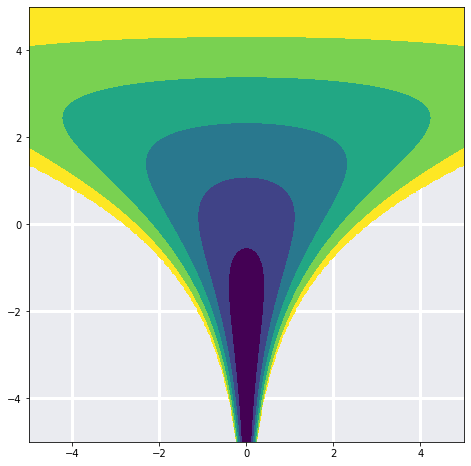

In [9]:
np.random.seed(0)
n = 500
min_x, max_x = -5, 5
min_y, max_y = -5, 5
x, z = np.meshgrid(np.linspace(min_x, max_x, n), np.linspace(min_y, max_y, n))
logp = norm.logpdf(z, 0, 3) + norm.logpdf(x, 0, np.exp(z / 2))

vmin = np.percentile(logp.flatten(), 42)

logp = np.where(logp < vmin, np.NaN, logp)

n_ticks, n_colors = 5, 6

fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.set_axisbelow(True)
ax.set_facecolor("#EAEBF0")
ax.grid(
    color="white",
    linestyle="-",
    linewidth=3,
)
ax.imshow(
    logp, cmap=matplotlib.cm.get_cmap("viridis_r", n_colors), extent=[min_x, max_x, min_y, max_y], origin="lower"
).set_zorder(1)
pml.savefig("neals-funnel.pdf")
plt.show()

centered


sample: 100%|██████████| 1000/1000 [00:02<00:00, 394.62it/s, 3 steps of size 4.38e-01. acc. prob=0.64]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -1.50      8.19     -0.00     -9.34      6.99     24.70      1.05
         y      1.06      2.51      0.66     -2.62      4.70     18.52      1.01

Number of divergences: 44
non-centered


sample: 100%|██████████| 1000/1000 [00:02<00:00, 369.07it/s, 1 steps of size 7.85e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     noise      0.07      1.00      0.08     -1.64      1.65    314.48      1.00
         x      0.69      6.39      0.03     -3.62      4.61    283.60      1.00
         y     -0.03      2.95      0.07     -4.70      4.96    279.12      1.00

Number of divergences: 0
reparam


sample: 100%|██████████| 1000/1000 [00:02<00:00, 412.66it/s, 1 steps of size 7.85e-01. acc. prob=0.93]
/home/patel_karm/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
             x      0.69      6.39      0.03     -3.62      4.61    283.60      1.00
  x_decentered      0.07      1.00      0.08     -1.64      1.65    314.48      1.00
             y     -0.03      2.95      0.07     -4.70      4.96    279.12      1.00

Number of divergences: 0


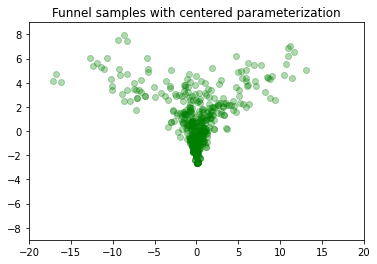

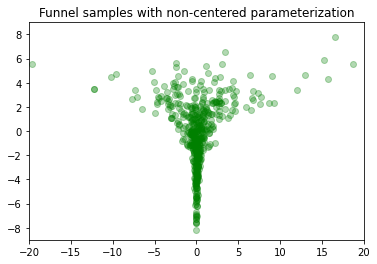

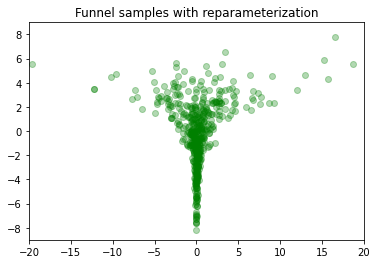

In [26]:
# Illustrate Neal's funnel
# Code based on
# https://numpyro.readthedocs.io/en/latest/examples/funnel.html


def model():
    y = numpyro.sample("y", dist.Normal(0, 3))
    numpyro.sample("x", dist.Normal(0, jnp.exp(y / 2)))


def noncentered_model():
    y = numpyro.sample("y", dist.Normal(0, 3))
    noise = numpyro.sample("noise", dist.Normal(0, 1))
    x = numpyro.deterministic("x", noise * jnp.exp(y / 2))


reparam_model = reparam(model, config={"x": LocScaleReparam(0)})


def run_inference(model):
    kernel = NUTS(model)
    rng_key = random.PRNGKey(0)
    mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=1)
    mcmc.run(rng_key)
    mcmc.print_summary(exclude_deterministic=False)
    return mcmc.get_samples()


print("centered")
samples = run_inference(model)

print("non-centered")
noncentered_samples = run_inference(noncentered_model)
noncentered_samples = Predictive(noncentered_model, noncentered_samples, return_sites=["x", "y"])(random.PRNGKey(1))

print("reparam")
reparam_samples = run_inference(reparam_model)
reparam_samples = Predictive(reparam_model, reparam_samples, return_sites=["x", "y"])(random.PRNGKey(1))

fig, ax = plt.subplots()
ax.plot(samples["x"], samples["y"], "go", alpha=0.3)
ax.set(
    xlim=(-20, 20),
    ylim=(-9, 9),
    title="Funnel samples with centered parameterization",
)
pml.savefig("funnel_plot_centered.pdf")

fig, ax = plt.subplots()
ax.plot(noncentered_samples["x"], noncentered_samples["y"], "go", alpha=0.3)
ax.set(
    xlim=(-20, 20),
    ylim=(-9, 9),
    title="Funnel samples with non-centered parameterization",
)
pml.savefig("funnel_plot_noncentered.pdf")

fig, ax = plt.subplots()
ax.plot(reparam_samples["x"], reparam_samples["y"], "go", alpha=0.3)
ax.set(
    xlim=(-20, 20),
    ylim=(-9, 9),
    title="Funnel samples with reparameterization",
)
pml.savefig("funnel_plot_reparam.pdf")